# Workflow for Tessellating Polygons
## Climate Data Statistics sampled across a region

This notebook demonstrates how to run a tessellation algorithm on a polygonal GeoDataFrame, to get climate data values across an entire region.

Note that this Notebook presumes an input in WGS84, although plots explicitly convert to Web Mercator in order to use basemaps. 

In [3]:
import os

API_KEY = os.getenv("SUST_API_KEY")
PROJECT = os.getenv("SUST_PROJECT")

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def tessellate_geometries(gdf, min_size_to_tesselate=0.6, grid_size=0.25):
    '''
        Tessellate geometries by overlaying a tile grid and intersecting large geometries.
        
        * `min_size_to_tesselate` is the area limit at which a geometry is split into tiles
        * `grid_size` is the tile size to use for geometries that need to be tiled
        
        Returns GeoDataFrame
    '''
    print(f"Input size, pre-tesselation: {gdf.shape[0]}")
    def tesselate_single_geom(g):
        if g.area > min_size_to_tesselate:
            xmin, ymin, xmax, ymax = g.bounds
            width, height = xmax - xmin, ymax - ymin
            grid_buff = []
            for x in np.arange(xmin, xmax, grid_size):
                for y in np.arange(ymin, ymax, grid_size):
                    grid_buff.append(
                        Polygon(
                            [
                                [x, y],
                                [x+grid_size, y],
                                [x+grid_size, y+grid_size],
                                [x          , y+grid_size],
                                [x          , y],
                            ]
                        ))
            intersections = [g.intersection(grid) for grid in grid_buff]
            return [i for i in intersections if not i.is_empty]

        return [g]
    
       
    tess_geoms = pd.concat([
        gdf,
        gdf.geometry.apply(tesselate_single_geom).rename('tesselated_geoms')
    ], axis=1).explode('tesselated_geoms')
    tess_geoms.geometry = tess_geoms.tesselated_geoms
    tess_geoms.drop('tesselated_geoms', inplace=True, axis=1)
    print(f"Output size, post-tesselation: {tess_geoms.shape[0]}")
    return tess_geoms

### Load National Forests data
This is volume mounted in at container run-time

In [5]:
national_forests = gpd.read_file('/app/data/national_forests.json')

Sample plot National Forests

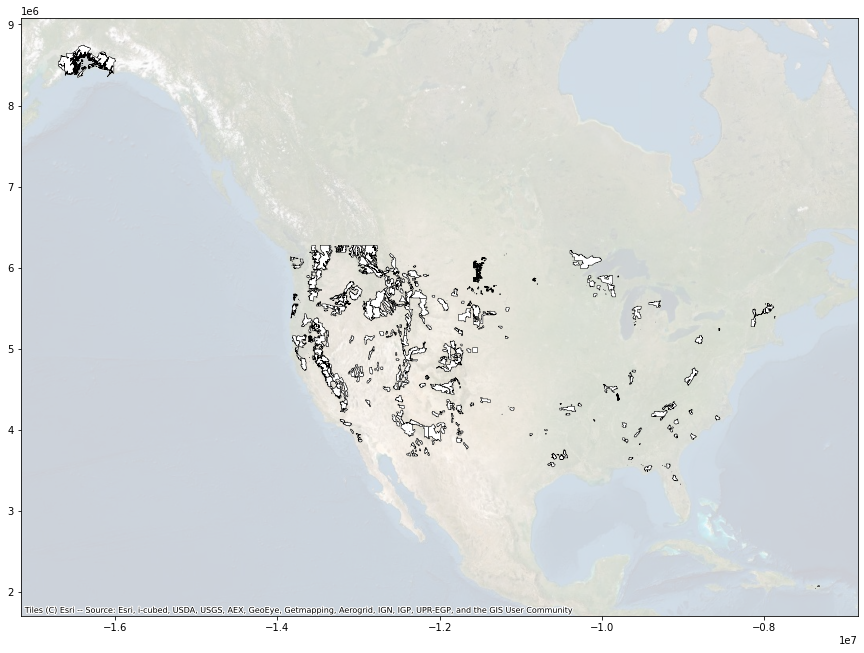

In [6]:
ax = national_forests.to_crs(epsg=3857).plot(
    figsize=(15,15),
    color="#ffffff",
    linewidth=0.5,
    edgecolor='k'
)
cx.add_basemap(
    ax, 
    source=cx.providers.Esri.WorldImagery, 
    alpha=0.2
)

Investigate a few of the larger national forests

In [7]:
large_forests = national_forests.sort_values("SHAPE_AREA", ascending=False).iloc[0:5]
large_forests

,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,FORESTNAME,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
2,99100400010343,10,04,1004,Chugach National Forest,6244703.986,4.146458,140.650701,"MULTIPOLYGON (((-149.56589 60.93605, -149.5658..."
18,99041700010343,04,17,0417,Humboldt-Toiyabe National Forest,6704118.270,2.833239,46.757032,"MULTIPOLYGON (((-120.12946 39.66529, -120.1294..."
69,99020600010343,02,06,0206,Medicine Bow-Routt National Forest,4592830.133,2.024215,28.015140,"MULTIPOLYGON (((-104.41720 44.18090, -104.4170..."
25,99041300010343,04,13,0413,Salmon-Challis National Forest,4396289.597,2.018913,24.663329,"MULTIPOLYGON (((-113.98046 45.70232, -113.9804..."
65,99090900010343,09,09,0909,Superior National Forest,3887905.471,1.892104,14.485443,"MULTIPOLYGON (((-93.18670 48.62786, -93.17991 ..."


### Plot Salmon-Challis National Forest, ID
Note that Salmon-Challis, like many parks, has multiple distinct park boundaries (aka it is a MultiPolygon).  The output of tessellation will have multiple rows, but each row can still potentially be a geometry if the tile overlaps more than one exterior ring (sub-Polygon).

,ADMINFORES,REGION,FORESTNUMB,FORESTORGC,FORESTNAME,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
25,99041300010343,04,13,0413,Salmon-Challis National Forest,4396289.597,2.018913,24.663329,"MULTIPOLYGON (((-113.98046 45.70232, -113.9804..."


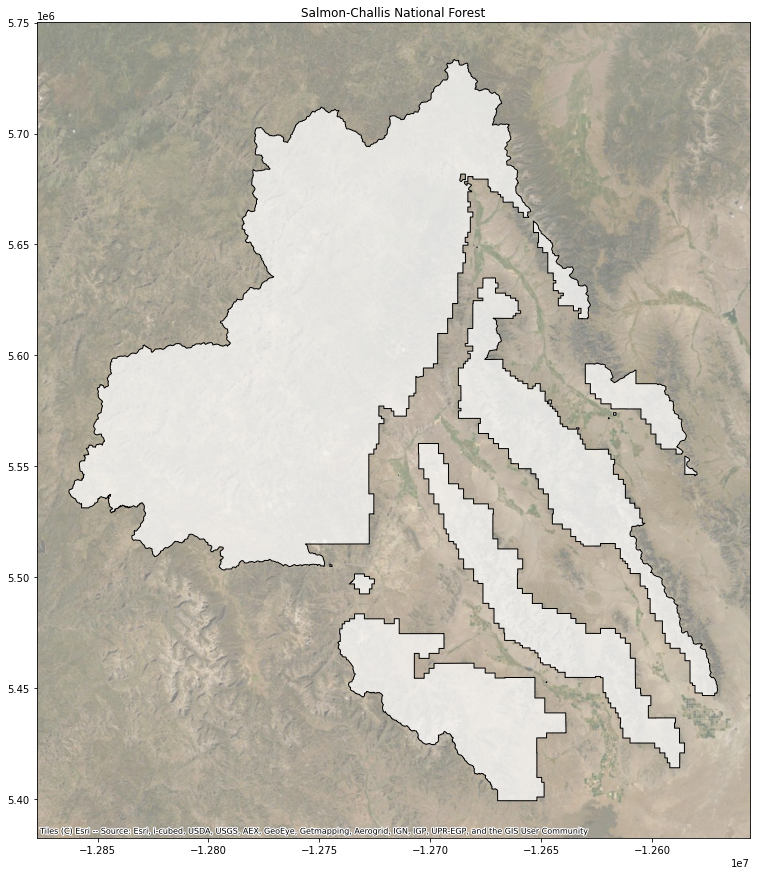

In [8]:
PARK_NAME='Salmon-Challis National Forest'
parks_to_plot = national_forests[national_forests['FORESTNAME'] == PARK_NAME]
ax = parks_to_plot.to_crs(epsg=3857).plot(
    figsize=(15,15), 
    linewidth=1, 
    edgecolor='k',
    color="#ffffffbb"
)
ax.set_title(PARK_NAME)
display(parks_to_plot)
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, alpha=0.5)


In [9]:
parks_to_plot_tessellated = tessellate_geometries(parks_to_plot)

Input size, pre-tesselation: 1
Output size, post-tesselation: 70


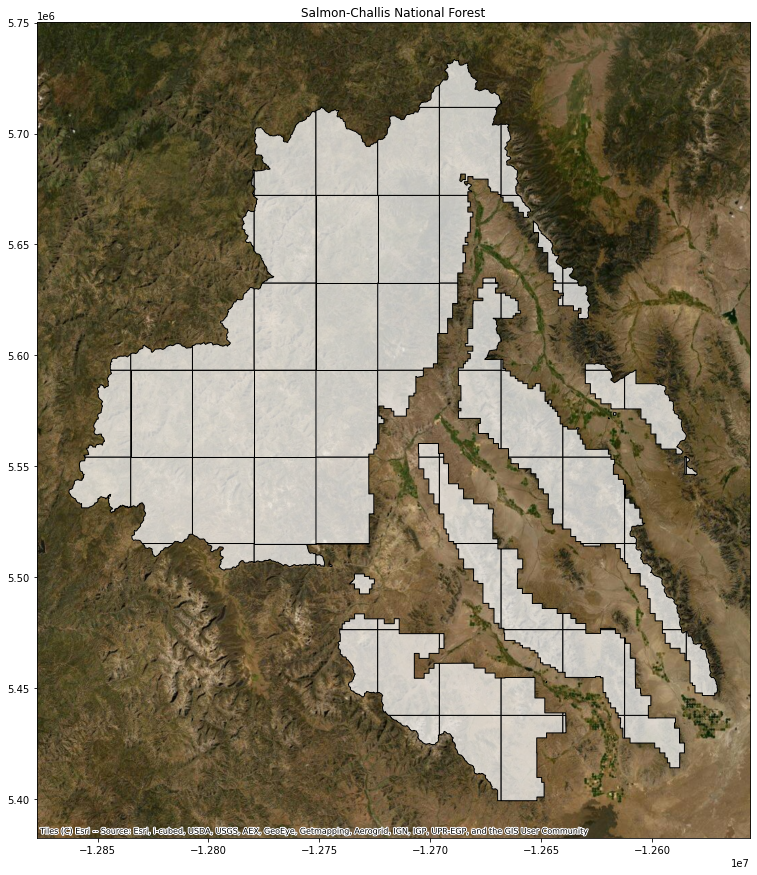

In [10]:
ax = parks_to_plot_tessellated.to_crs(epsg=3857).plot(
    figsize=(15,15), 
    linewidth=1, 
    edgecolor='k',
    color="#ffffffbb"
)
ax.set_title(PARK_NAME)
ax.set_aspect('equal')
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)

### Work with the Sust Global API to upload Tessellated Regions

Create a portfolio for tessellated assets

In [61]:
import requests, json

PORTFOLIO = "tessellated_salmon_challis"

endpoints = {
    "portfolio": f"https://explorer.sustglobal.io/api/portfolios/?api_key={API_KEY}&project={PROJECT}",
    "asset_import": f"https://explorer.sustglobal.io/api/portfolios/{PORTFOLIO}/assets/import/?api_key={API_KEY}&project={PROJECT}"
}

def check_status(portfolio_name):
    status = requests.get(endpoints["portfolio"])
    print([i for i in json.loads(status.content) if i['portfolio_name'] == portfolio_name])


In [ ]:
x = requests.post(endpoints["portfolio"], json = {"portfolio_name": PORTFOLIO})
x

Check the status of the above portfolio:

In [63]:
check_status(PORTFOLIO)

[{'portfolio_id': '49cf2bdf5215937b', 'portfolio_name': 'tessellated_salmon_challis', 'created_at': '2022-08-16T00:15:26Z', 'updated_at': '2022-08-16T00:34:41Z', 'status': 'Waiting on risk data generation'}]


Tessellate all national forests, as above

In [64]:
with open(temporary_output, 'rb') as infile:
    status = requests.post(endpoints["asset_import"], files={
        'asset': ('tessellated_salmon_challis.json', parks_to_plot_tessellated.to_json())
    })
    print(status)

<Response [202]>


In [65]:
check_status(PORTFOLIO)

[{'portfolio_id': '49cf2bdf5215937b', 'portfolio_name': 'tessellated_salmon_challis', 'created_at': '2022-08-16T00:15:26Z', 'updated_at': '2022-08-16T00:45:14Z', 'status': 'Waiting on risk data generation'}]
